In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataaafood/en.openfoodfacts.org.products.csv


In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder \
    .appName("OpenFoodFacts Ingestion") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/01 15:28:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.csv("/kaggle/input/dataaafood/en.openfoodfacts.org.products.csv", 
                    sep="\t", 
                    header=True, 
                    inferSchema=True)


In [6]:
print("Nombre total de produits :", df.count())

Nombre total de produits : 3859643


In [7]:
df.printSchema()


root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- last_modified_by: string (nullable = true)
 |-- last_updated_t: integer (nullable = true)
 |-- last_updated_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- brands_en: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- catego

In [8]:
from pyspark.sql.functions import col, lower, regexp_replace, array_contains, upper, udf
from pyspark.sql.types import ArrayType, StringType

In [9]:
from pyspark.sql.functions import col

# On garde les lignes avec des champs non nuls
df_clean = df.filter(
    col("product_name").isNotNull() &
    col("ingredients_text").isNotNull() &
    col("nutriscore_score").isNotNull() &
    col("countries_tags").isNotNull()
)

# On filtre pour ne garder que les produits uniquement en France, Italie ou Espagne
df_clean = df_clean.filter(
    (col("countries_tags").rlike("^(en:france|en:italy|en:spain)(,en:france|,en:italy|,en:spain)*$"))
)

print("Produits valides uniquement pour France, Italie ou Espagne :", df_clean.count())


Produits valides uniquement pour France, Italie ou Espagne : 246774


In [10]:
#nettoyage du product name
from pyspark.sql.functions import lower, regexp_replace

df_clean = df_clean.withColumn("product_name", lower(col("product_name")))
df_clean = df_clean.withColumn("product_name", regexp_replace(col("product_name"), "[^a-zA-Z0-9\\s]", ""))


In [11]:
#nettoyage des ingredients
df_clean = df_clean.withColumn("ingredients_text", lower(col("ingredients_text")))
df_clean = df_clean.withColumn("ingredients_text", regexp_replace(col("ingredients_text"), "[^a-zA-Z0-9\\s]", " "))
df_clean = df_clean.withColumn("ingredients_text", regexp_replace(col("ingredients_text"), "\\s+", " "))

In [12]:
df = df.dropna(subset=["product_name", "ingredients_text", "nutriscore_score", "nutriscore_grade"])


In [13]:
colonnes_pertinentes = [
    "product_name", "brands", "categories", "countries_en", "ingredients_text",
    "nutriscore_score", "nutriscore_grade", "nova_group",
    "energy-kcal_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g",
    "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"
]


In [14]:
df = df.select(colonnes_pertinentes)
df = df.dropna(subset=colonnes_pertinentes)

In [15]:
df = df.filter(df["nutriscore_grade"].isin(["a", "b", "c", "d", "e"]))
#Filtrer les valeurs valides de nutriscore_grade (entre 'a' et 'e')

In [16]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

colonnes_numeriques = [
    "energy-kcal_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g",
    "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"
]

for c in colonnes_numeriques:
    df = df.withColumn(c, col(c).cast(FloatType()))
#Convertir les colonnes numériques

In [17]:
df.write.mode("overwrite").parquet("/kaggle/working/data_clean_parquet")


In [18]:
import os
os.listdir("/kaggle/working/")


['.virtual_documents', 'data_clean_parquet']

In [19]:
import pandas as pd

df_pandas = pd.read_parquet("/kaggle/working/data_clean_parquet")


In [20]:
df_pandas.shape
df_pandas.sample(5)
df_pandas.columns


Index(['product_name', 'brands', 'categories', 'countries_en',
       'ingredients_text', 'nutriscore_score', 'nutriscore_grade',
       'nova_group', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g'],
      dtype='object')

In [21]:
df_pandas[["product_name", "ingredients_text", "nutriscore_grade"]].isnull().sum()


product_name        0
ingredients_text    0
nutriscore_grade    0
dtype: int64

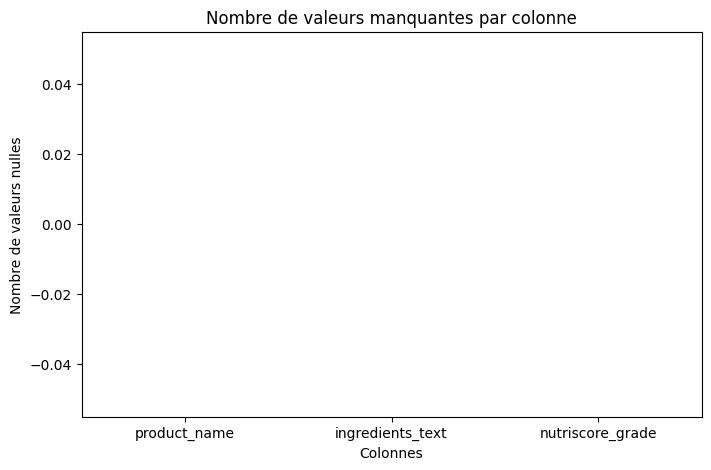

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul du nombre de valeurs nulles par colonne
null_counts = df_pandas[["product_name", "ingredients_text", "nutriscore_grade"]].isnull().sum()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")
plt.title("Nombre de valeurs manquantes par colonne")
plt.ylabel("Nombre de valeurs nulles")
plt.xlabel("Colonnes")
plt.show()


In [23]:
df_pandas["nutriscore_grade"].value_counts()


nutriscore_grade
e    99478
d    91446
c    83906
a    65828
b    39047
Name: count, dtype: int64

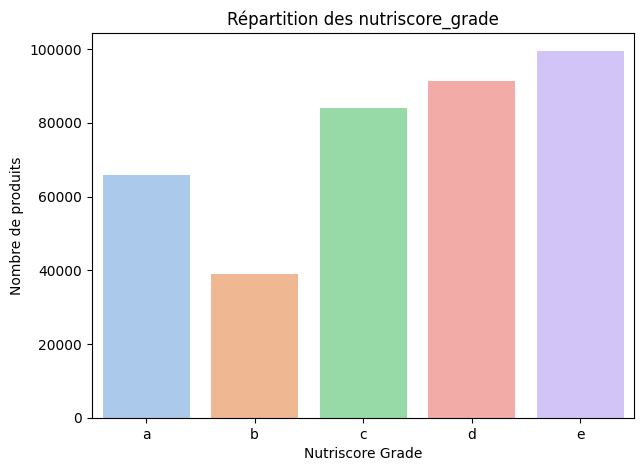

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comptage des valeurs
counts = df_pandas["nutriscore_grade"].value_counts().sort_index()

# Plot
plt.figure(figsize=(7,5))
sns.barplot(x=counts.index, y=counts.values, palette="pastel")
plt.title("Répartition des nutriscore_grade")
plt.xlabel("Nutriscore Grade")
plt.ylabel("Nombre de produits")
plt.show()


In [25]:
num_cols = ["energy-kcal_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g",
            "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"]

df_pandas[num_cols].describe()


,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,3.797050e+05,379705.000000,379705.000000,379705.000000,379705.000000,3.797050e+05,379705.000000,379705.000000,379705.000000
mean,3.368290e+02,15.768144,5.343927,37.528049,15.786123,1.609471e+07,8.931303,1.416531,0.566581
std,6.018226e+03,44.614380,11.644874,53.847488,33.991505,9.917592e+09,21.829199,40.207260,16.080311
min,0.000000e+00,0.000000,0.000000,0.000000,-1.450000,0.000000e+00,-12.600000,0.000000,0.000000
25%,1.120000e+02,1.180000,0.100000,7.000000,1.200000,0.000000e+00,2.100000,0.030000,0.012000
50%,2.812500e+02,7.500000,1.700000,24.690001,4.580000,1.700000e+00,6.200000,0.470000,0.188000
75%,4.333333e+02,21.430000,6.670000,58.299999,20.799999,4.000000e+00,11.100000,1.120000,0.449000
max,3.701123e+06,20300.000000,972.000000,2300.000000,1900.000000,6.111242e+12,9100.000000,17340.000000,6936.000000


In [26]:
valid_ranges = {
    "energy-kcal_100g": (0, 1200),
    "fat_100g": (0, 100),
    "saturated-fat_100g": (0, 80),
    "carbohydrates_100g": (0, 200),
    "sugars_100g": (0, 150),
    "fiber_100g": (0, 99),
    "proteins_100g": (0, 100),
    "salt_100g": (0, 100),
    "sodium_100g": (0, 40)
}


In [27]:
for col, (min_val, max_val) in valid_ranges.items():
    df_pandas[col] = pd.to_numeric(df_pandas[col], errors="coerce")
    df_pandas.loc[(df_pandas[col] < min_val) | (df_pandas[col] > max_val), col] = None


In [28]:
num_cols = ["energy-kcal_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g",
            "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"]

df_pandas[num_cols].describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,371255.000000,375152.000000,378670.000000,374734.000000,377247.000000,379511.000000,378824.000000,379505.000000,379505.000000
mean,285.981476,13.620718,5.002126,33.337769,13.981362,3.260390,8.493731,0.937149,0.374860
std,197.547440,16.952059,8.236529,30.557068,20.104298,5.316283,9.852396,2.794251,1.117656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.000000,1.100000,0.100000,6.842500,1.200000,0.000000,2.100000,0.030000,0.012000
50%,273.000000,7.170000,1.700000,23.700001,4.500000,1.700000,6.200000,0.468000,0.187000
75%,424.000000,21.000000,6.670000,57.142857,20.000000,4.000000,11.000000,1.120000,0.448000
max,1200.000000,100.000000,80.000000,200.000000,150.000000,98.000000,100.000000,100.000000,40.000000


In [29]:
#enlever toutes les lignes qui ont des valeurs manquantes dans les colonnes définies dans valid_ranges
df_pandas.dropna(subset=list(valid_ranges.keys()), inplace=True)


In [30]:
df_pandas["ingredients_text"].sample(5).tolist()


['Oats, cane sugar, soy protein isolate, canola oil, semi-sweet chocolate (sugar, unsweetened chocolate, cocoa butter, soy lecithin, vanilla extract), banana, peanut butter (peanuts, salt), oat flour, peanuts, water, gum acacia, peanut oil, peanut flour, millet, buckwheat, amaranth, quinoa, natural flavor, sea salt, vitamin e (tocopherols to maintain freshness).',
 "Farine de BLÉ 56% (origine France), beurre concentré (LAIT) 25% (soit 30% en beurre reconstitué), sucre, ŒUFS poudres à lever : carbonates d'ammonium, diphosphates de sodium, carbonates de sodium jaune d'ŒUF, sel, LAIT écrémé en poudre. Traces éventuelles de soja, moutarde et de fruits à coque. Elaboré à partir de lait origine UE et hors UE.",
 'Wasser, Sonnenblumenöl, 10 % Shiitakes, 8% Champignons, Kartoffelstärke, 8 % Hefe getrocknet, pflanzliches Eiweiß (aus Sonnenblumenkernen), Meersalz, Zwiebelpulver, Knoblauchpulver, weißer Pfeffer, Kurkuma',
 'Wheat flour, Sugar, Glucose syrup, Vegetable Shortening, Non hydrogenated

In [31]:
df_pandas.duplicated(subset=["product_name", "ingredients_text"]).sum()


9706

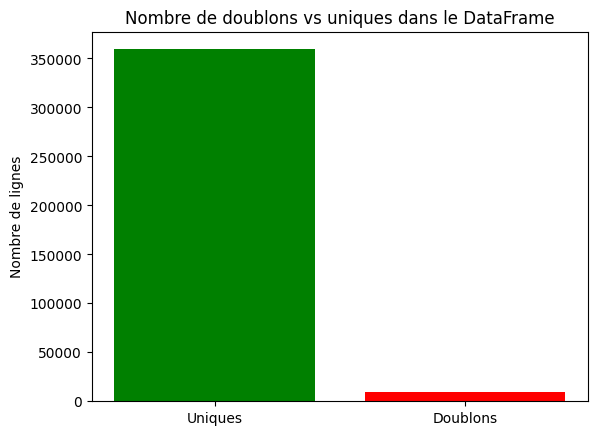

In [32]:
import matplotlib.pyplot as plt

# Nombre total de lignes
total = len(df_pandas)

# Nombre de doublons (sur les colonnes product_name + ingredients_text)
duplicates = df_pandas.duplicated(subset=["product_name", "ingredients_text"]).sum()

# Nombre de lignes uniques
uniques = total - duplicates

# Création du graphique
plt.bar(["Uniques", "Doublons"], [uniques, duplicates], color=["green", "red"])
plt.title("Nombre de doublons vs uniques dans le DataFrame")
plt.ylabel("Nombre de lignes")
plt.show()


In [33]:
df_pandas.drop_duplicates(subset=["product_name", "ingredients_text"], inplace=True)
df_pandas.duplicated(subset=["product_name", "ingredients_text"]).sum()


0

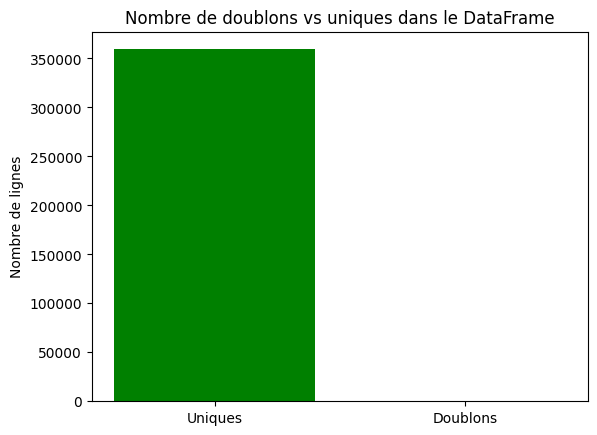

In [34]:
import matplotlib.pyplot as plt

# Nombre total de lignes
total = len(df_pandas)

# Nombre de doublons (sur les colonnes product_name + ingredients_text)
duplicates = df_pandas.duplicated(subset=["product_name", "ingredients_text"]).sum()

# Nombre de lignes uniques
uniques = total - duplicates

# Création du graphique
plt.bar(["Uniques", "Doublons"], [uniques, duplicates], color=["green", "red"])
plt.title("Nombre de doublons vs uniques dans le DataFrame")
plt.ylabel("Nombre de lignes")
plt.show()


In [35]:
assert df_pandas["product_name"].isnull().sum() == 0
assert df_pandas["ingredients_text"].isnull().sum() == 0
assert df_pandas.shape[0] > 100  # pour que ce soit utile


In [36]:
df_pandas.shape


(359373, 17)

In [37]:
print(df_pandas.columns)


Index(['product_name', 'brands', 'categories', 'countries_en',
       'ingredients_text', 'nutriscore_score', 'nutriscore_grade',
       'nova_group', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g'],
      dtype='object')


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_pandas["product_name"])


In [52]:
def recommend_by_each_ingredient(ingredients, filters=None):
    # Copie du DataFrame principal
    filtered_df = df_pandas.copy()

    # Nettoyage de certains champs
    filtered_df["nova_group"] = pd.to_numeric(filtered_df["nova_group"], errors="coerce")
    filtered_df["ingredients_text"] = filtered_df["ingredients_text"].astype(str)

    # Application des filtres facultatifs
    if filters:
        for key, value in filters.items():
            if value:
                if key == "nova_group":
                    try:
                        value = int(value)
                        filtered_df = filtered_df[filtered_df["nova_group"] == value]
                    except ValueError:
                        continue
                else:
                    filtered_df = filtered_df[
                        filtered_df[key].astype(str).str.contains(str(value), case=False, na=False)
                    ]

    # Résultats finaux
    final_result = pd.DataFrame()

    # Boucle sur les ingrédients recherchés
    for ingredient in ingredients:
        # Filtrage strict par mot dans les ingrédients (pas juste une sous-chaîne)
        match = filtered_df[
            filtered_df["ingredients_text"].str.contains(rf"\b{ingredient}\b", case=False, na=False)
        ]
        final_result = pd.concat([final_result, match])

    # Suppression des doublons éventuels
    final_result = final_result.drop_duplicates()

    # Tri par score nutritionnel (meilleurs d'abord)
    final_result = final_result.sort_values(by="nutriscore_score", ascending=True)

    # Affichage des colonnes utiles
    display(
        final_result[
            ["product_name", "brands", "categories", "countries_en",
             "ingredients_text", "nutriscore_score", "nutriscore_grade", "nova_group"]
        ].head(10)
    )


In [48]:
ingredients = ["milk", "chocolate", "sugar", "oil"]

filters = {
    "countries_en": "Spain",  # optionnel
}

recommend_by_each_ingredient(ingredients, filters)


,product_name,brands,categories,countries_en,ingredients_text,nutriscore_score,nutriscore_grade,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,matched_ingredient
167236,British Whole Milk,Asda,"Dairies, Milks, Pasteurised milks, Whole milks...","Spain,United Kingdom",milk,6,c,1,66.000000,3.700000,2.400000,4.700000,4.700000,0.000,3.5000,0.531000,0.212400,milk
268454,Fat Free Greek Natural Yogurt,Milbona,en:greek-style-yogurts,"Spain,United Kingdom",Milk,0,a,1,68.000000,0.200000,0.200000,9.200000,9.200000,0.500,7.0000,0.150000,0.060000,milk
285029,Organic Lactose Free Milk Drink,Auga,"Dairies, Milks, Whole milks","Latvia,Lithuania,Spain,Ukraine","Organic milk, enzyme lactase.",-1,b,1,48.000000,2.500000,1.600000,2.900000,2.900000,0.000,3.5000,0.100000,0.040000,milk
320102,Kefir,Arla,"Beverages, Dairies, Fermented foods, Fermented...","Spain,United Kingdom","Organic milk, Kefir culture (milk)",2,b,1,59.000000,3.000000,1.900000,3.900000,3.900000,0.000,3.4000,0.100000,0.040000,milk
333108,Philadelphia Light,"Mondelēz, Philadelphia","Laticínios,Alimentos Fermentados,Produtos láct...","France,Spain","whole milk, milk protein preparation, cream, s...",8,c,3,147.000000,10.700000,7.000000,5.000000,5.000000,0.400,7.3300,0.700000,0.280000,milk
275775,Milk Chocolate with Almonds,choceur,"Botanas, Snacks dulces, Cacao y sus productos,...","Spain,United States","Milk chocolate (sugar, milk, cocoa butter, cho...",24,e,4,600.000000,40.000000,16.666700,46.666698,40.000000,6.700,13.3333,0.166667,0.066667,chocolate
111109,Hershey's With Almond,Hershey's,"Snacks, Sweet snacks, Cocoa and its products, ...","Spain,United States","milk chocolate [sugar, milk, chocolate, cocoa ...",28,e,4,512.000000,31.700001,14.600000,53.700001,48.799999,4.880,9.7600,0.152000,0.061000,chocolate
219687,Arroz inflado con chocolate,Harrisons,"Alimentos y bebidas de origen vegetal, Aliment...",Spain,"Arroz (65%), azûcar, chocolate (15%) (chocolat...",19,e,4,395.000000,2.500000,1.300000,85.000000,32.000000,2.500,5.5000,1.075000,0.430000,chocolate
354674,Opti Pro bebida de chocolate con proteínas,Río de Galicia,"Bebidas, Lácteos, Bebida lácteas, Leches aroma...",Spain,"Leche desnatada ultrafiltrada 96%, chocolate d...",4,c,4,55.799999,0.394000,0.212000,4.850000,4.550000,0.606,8.1800,0.119000,0.047600,chocolate
352956,Batido de chocolate,Central Lechera Asturiana,"Bebidas, Lácteos, Bebida lácteas, Leches aroma...","France,Spain","leche semidesnatada 92%, azucar de caña, cacao...",8,d,3,68.000000,1.600000,1.100000,10.000000,9.800000,0.300,3.2000,0.100000,0.040000,chocolate


In [79]:
ingredients = ["lentilles"]

filters = {
    "countries_en": "france",  # optionnel
    #"nutriscore_grade" : "b",
    #"nova_group" : "4"
}

recommend_by_each_ingredient(ingredients, filters)


,product_name,brands,categories,countries_en,ingredients_text,nutriscore_score,nutriscore_grade,nova_group
218045,Lentilles rouges corail,Moulin des moines,"Aliments et boissons à base de végétaux, Alime...",France,Lentilles rouges* *issues de l'agriculture bio...,-17,a,1
277797,Lentilles corail,Naturalia,"Aliments et boissons à base de végétaux, Alime...",France,Lentilles corail&quot; (Turquie).,-17,a,1
233149,"Trio de lentilles Vertes, Blondes et Brunes","Carrefour BIO, Carrefour","Aliments et boissons à base de végétaux, Alime...","France,Italy,Spain","Lentilles vertes*34%, lentilles blondes*33%, l...",-17,a,1
218195,Lentilles corail,Moulin des Moines,"Aliments et boissons à base de végétaux, Alime...",France,Lentilles rouges.,-17,a,1
216259,Lentilles corail,"OFAL Bio, Ofal","Aliments et boissons à base de végétaux, Alime...",France,Lentilles rouges biologiques.,-17,a,1
180368,Lentilles vertes,Sabarot,"Aliments et boissons à base de végétaux, Alime...",France,Lentilles vertes,-17,a,1
202971,Lentille verte,Mon Panier Sans Gluten,"Aliments et boissons à base de végétaux, Alime...",France,Lentilles vertes entières bio origine France,-17,a,1
248526,Lentilles Vertes Bio Origine France,"Sans marque, grain de vitalité","Aliments et boissons à base de végétaux, Alime...",France,Lentilles vertes,-16,a,1
180415,Lentilles corail Bio,Sabarot,"Aliments et boissons à base de végétaux,Alimen...",France,Lentilles corail,-16,a,1
219690,Lentilles beluga,Primeal,"Aliments et boissons à base de végétaux, Alime...",France,Lentilles,-16,a,1


In [55]:
import joblib
import pandas as pd

# ✅ 1. Sauvegarder le vectorizer TF-IDF entraîné
# Cela permet de le recharger plus tard dans ton backend
joblib.dump(vectorizer, "model.pkl")  # vectorizer est ton TF-IDF entraîné

# ✅ 2. Spécifier les colonnes pertinentes pour ton application
colonnes_pertinentes = [
    "product_name", "brands", "categories", "countries_en", "ingredients_text",
    "nutriscore_score", "nutriscore_grade", "nova_group",
    "energy-kcal_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g",
    "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g"
]

# ✅ 3. Filtrer le DataFrame pour ne garder que ces colonnes
df_clean = df_pandas[colonnes_pertinentes]

# ✅ 4. Sauvegarder dans un fichier CSV (clean et prêt à être chargé dans le backend)
df_clean.to_csv("products_clean_final.csv", index=False)


In [43]:
for col in df_pandas.columns:
    print(f"\n🟦 Colonne : {col}")
    print(df_pandas[col].dropna().unique())
    print(f"Total valeurs uniques : {df_pandas[col].nunique()}")



🟦 Colonne : product_name
['five grain granola' 'Natual Energy Boost' 'Madeleines ChocoLait' ...
 'strawberry fruit balls' 'fennel Tuscan' 'Paprikás Kukorica csemege']
Total valeurs uniques : 287655

🟦 Colonne : brands
['Roger’s' 'Everydays' 'Apple bandit' ... 'GRANDIOSE BAKER' 'Thymos'
 'oh my']
Total valeurs uniques : 77301

🟦 Colonne : categories
['Plant-based foods and beverages, Plant-based foods, Breakfasts, Cereals and potatoes, Cereals and their products, Breakfast cereals, Flakes, Cereal flakes, Condiment'
 'Beverages and beverages preparations, Beverages, Snacks, Desserts, Sweet snacks, Biscuits and cakes, Biscuits and crackers, Biscuits, Cakes, Pound Cake, Madeleines, Plain madeleines'
 'Snacks, Snacks sucrés, Biscuits et gâteaux, Gâteaux, Gâteaux au chocolat, Madeleines, Madeleines au chocolat'
 ... 'Viandes et dérivés, Charcuteries, Saucisses, Saucisses de volaille'
 'Bonen' 'Extrudált Kukorica']
Total valeurs uniques : 102206

🟦 Colonne : countries_en
['France,Germany' 'F

In [44]:
ingredients = ["tea"]

filters = {
    "countries_en": "Spain",  # optionnel
}

recommend_by_each_ingredient(ingredients, filters)


,product_name,brands,categories,countries_en,ingredients_text,nutriscore_score,nutriscore_grade,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,matched_ingredient
168063,Green tea Bancha,Vitasia,"Plant-based foods and beverages, Beverages, Pl...","France,Spain",green tea,0,b,1,1.000000,0.500000,0.100000,0.50000,0.500000,0.5,0.010000,0.000000,0.000000,tea
294874,Decaf tea,Typhoo,"Plant-based foods and beverages, Beverages, Ho...","Spain,United States",Black tea,0,b,1,5.000000,0.100000,0.100000,0.20000,0.200000,0.2,0.100000,0.100000,0.040000,tea
367090,Yula acai berry spice,Yula,"Plant-based foods and beverages, Beverages, Pl...","Belgium,Spain","Sparkling water, sugar, lemon juice from conce...",6,c,4,23.000000,0.500000,0.100000,5.60000,5.300000,0.0,0.500000,0.010000,0.004000,tea
117559,Tiger spice decaffeinated chai,david rio,"Plant-based foods and beverages, Beverages, Ho...","Spain,United States","Cane sugar, coconut oil, corn syrup solids, ho...",21,e,4,429.000000,10.710000,7.140000,75.00000,64.290001,0.0,3.570000,0.222500,0.089000,tea
372959,Lotte Choco pies (green tea),Lotte,"Snacks, Sweet snacks, Cocoa and its products, ...","Spain,United States","Sugar, wheat flour, corn syrup, shortening(par...",26,e,4,464.285706,17.857143,14.285714,67.85714,32.142857,1.0,3.571429,0.446429,0.178571,tea
